# Conversion timing

## Loading libraries

In [1]:
# env: zanalytics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score
import joblib

## Creating synthetic data

In [2]:
# --- 1. Generating Synthetic Data ---
np.random.seed(42)
n = 5000  # number of users

In [3]:
tenant_ids = np.random.choice(['A', 'B', 'C'], size=n)
user_ids = np.arange(1, n + 1)
gender = np.random.choice(['male', 'female', 'other'], size=n, p=[0.45, 0.45, 0.1])
time_after_inflow = np.random.exponential(scale=30, size=n)
day_of_week = np.random.choice(range(7), size=n)
hour_of_day = np.random.choice(range(24), size=n)

In [4]:
# Conversion logic
base_prob = (
    0.15
    + 0.1 * np.isin(day_of_week, [5, 6])  # weekends
    + 0.2 * ((hour_of_day >= 13) & (hour_of_day <= 18))  # afternoons
    + 0.05 * (gender == 'female')
    + 0.05 * (tenant_ids == 'A')
)
converted = np.random.binomial(1, np.clip(base_prob, 0, 1))

In [5]:
df = pd.DataFrame({
    'tenant_id': tenant_ids,
    'gender': gender,
    'time_after_inflow_min': time_after_inflow,
    'day_of_week': day_of_week,
    'hour_of_day': hour_of_day,
    'converted': converted
})
df.head()

,tenant_id,gender,time_after_inflow_min,day_of_week,hour_of_day,converted
0,C,male,70.183034,5,2,0
1,A,male,3.529566,6,19,0
2,C,female,5.848400,4,13,0
3,C,male,16.793377,6,8,1
4,A,female,4.064722,2,8,0


## Pt.1: Creating model

In [6]:
# --- 2. Encode and Train Model to Predict Conversion Time ---
# Let's predict (day_of_week, hour_of_day) given user and tenant info

# Features
X = pd.get_dummies(df[['tenant_id', 'gender', 'time_after_inflow_min']], drop_first=True)

# Targets: we'll merge day and hour into a single label "conversion_slot"
df['conversion_slot'] = df['day_of_week'] * 24 + df['hour_of_day']
y = df['conversion_slot']

In [7]:
y.unique()

array([122, 163, 109, 152,  56,  44,   5,   7, 106, 103,  35, 105, 118,
         3,  39, 139, 101,  32,  70,   4, 140,  23,  88,  40,  71, 117,
        60,  13,  73,  42, 121,  25,  54,  51, 112,  77,   6, 149,   8,
        75, 100, 162,  33,  65,  38,  48,  28,  93,  45,  91,  86, 114,
       132, 116, 153,  89, 147,  21,  30,  31, 151,  10, 128,  67,  15,
        26, 138,  55,  76,  49, 119,  90,  84,  29,  53,  97,  47, 154,
       167, 133,  12,  79, 110,  83,  50,  20,  46, 145, 160,  82,  80,
       156,  16, 129,  72,  58, 104, 126, 113,  19, 107,  22,  63, 111,
        92,  66,  24,  99,  27, 142, 165,  96, 123, 131,  69, 135,  14,
       143, 161, 137,  43, 146,  64, 150,  57,  34,  87, 120,  68, 115,
         0, 148,  41,  37,  52, 134, 141, 144, 166,  85, 127,  36, 108,
       124,  62, 157, 158,  81,  95, 130,   2, 155,  11,  94,  74,  18,
       125,  61, 164,  17,  59,  78, 102, 159,   9,  98, 136,   1])

In [8]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [9]:
n_estimators = 10

In [10]:
# Model
model = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


### Saving model

In [12]:
joblib.dump({
    "model": model,
    "columns": X_train.columns
}, "conversion_model_bundle.pkl")

['conversion_model_bundle.pkl']

### Loading model

In [22]:
# Load later

bundle = joblib.load("conversion_model_bundle.pkl")
loaded_model = bundle["model"]
X_columns = bundle["columns"]


# Example: use it for prediction
sample = pd.DataFrame({
    'tenant_id': ['A'],
    'gender': ['female'],
    'time_after_inflow_min': [10],
    'day_of_week': [5],
    'hour_of_day': [15]
})

# Encode same way as before
sample_encoded = pd.get_dummies(sample, drop_first=True).reindex(columns=X_columns, fill_value=0)
predicted_prob = loaded_model.predict_proba(sample_encoded)[0, 1]

print(f"Predicted conversion probability: {predicted_prob:.3f}")


Predicted conversion probability: 0.000


In [13]:
# Evaluate
print("\nModel performance:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nExample slots predicted (0=Mon 0h … 167=Sun 23h):")
print(y_pred[:10])

# --- 3. Predict the most likely conversion time for a new user ---
sample = pd.DataFrame({
    'tenant_id': ['A'],
    'gender': ['female'],
    'time_after_inflow_min': [10]
})
sample_encoded = pd.get_dummies(sample, drop_first=True).reindex(columns=X.columns, fill_value=0)
slot_pred = model.predict(sample_encoded)[0]
day = slot_pred // 24
hour = slot_pred % 24

print(f"\nPredicted best conversion time: Day {day} (0=Mon) at {hour}:00h")



Model performance:
Accuracy: 0.005333333333333333

Example slots predicted (0=Mon 0h … 167=Sun 23h):
[ 94  32  56  10 135 159 157 111   9 126]

Predicted best conversion time: Day 1 (0=Mon) at 12:00h


## Pt.2: Creating model and heatmap with probabilities

In [14]:
# --- 2. Prepare Features ---
X = pd.get_dummies(df[['tenant_id', 'gender', 'time_after_inflow_min', 'day_of_week', 'hour_of_day']], drop_first=True)
y = df['converted']

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [16]:
# --- 3. Train Model ---
model = RandomForestClassifier(n_estimators=150, random_state=42)
model.fit(X_train, y_train)
y_pred_proba = model.predict_proba(X_test)[:, 1]

auc = roc_auc_score(y_test, y_pred_proba)
print(f"Model AUC: {auc:.3f}")

Model AUC: 0.599


In [17]:
# --- 4. Predict Conversion Probabilities for Each Day/Hour ---
grid = pd.DataFrame([(d, h) for d in range(7) for h in range(24)], columns=['day_of_week', 'hour_of_day'])

grid['tenant_id'] = 'A'
grid['gender'] = 'female'
grid['time_after_inflow_min'] = 10  # assume user just started

grid_encoded = pd.get_dummies(grid, drop_first=True).reindex(columns=X.columns, fill_value=0)
grid['predicted_conversion_prob'] = model.predict_proba(grid_encoded)[:, 1]

In [20]:
grid

,day_of_week,hour_of_day,tenant_id,gender,time_after_inflow_min,predicted_conversion_prob
0,0,0,A,female,10,0.113333
1,0,1,A,female,10,0.113333
2,0,2,A,female,10,0.660000
3,0,3,A,female,10,0.553333
4,0,4,A,female,10,0.133333
...,...,...,...,...,...,...
163,6,19,A,female,10,0.160000
164,6,20,A,female,10,0.246667
165,6,21,A,female,10,0.133333
166,6,22,A,female,10,0.073333


In [18]:
# --- 5. Find Top 3 Best Times ---
top3 = grid.nlargest(3, 'predicted_conversion_prob')
top3['day_name'] = top3['day_of_week'].map({
    0: 'Mon', 1: 'Tue', 2: 'Wed', 3: 'Thu', 4: 'Fri', 5: 'Sat', 6: 'Sun'
})

print("\n🔥 Top 3 Best Conversion Time Slots:")
for _, row in top3.iterrows():
    print(f"  • {row['day_name']} at {int(row['hour_of_day']):02d}:00 → "
          f"Predicted Probability: {row['predicted_conversion_prob']:.3f}")


🔥 Top 3 Best Conversion Time Slots:
  • Wed at 05:00 → Predicted Probability: 0.860
  • Sat at 15:00 → Predicted Probability: 0.787
  • Sat at 21:00 → Predicted Probability: 0.733


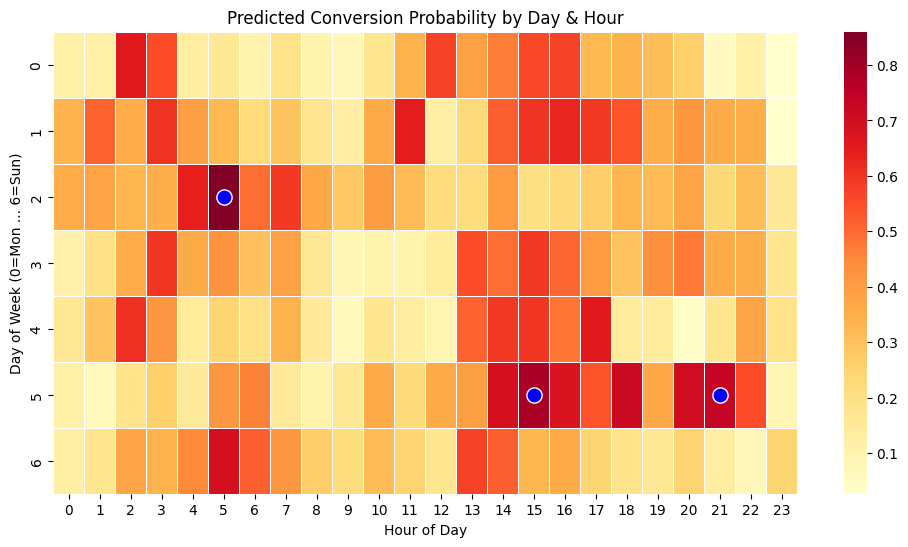

In [19]:
# --- 6. Plot Heatmap ---
#pivot = grid.pivot('day_of_week', 'hour_of_day', 'predicted_conversion_prob')
pivot = grid.pivot(index='day_of_week', columns='hour_of_day', values='predicted_conversion_prob')

plt.figure(figsize=(12, 6))
sns.heatmap(pivot, cmap='YlOrRd', linewidths=0.5)
plt.title('Predicted Conversion Probability by Day & Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week (0=Mon ... 6=Sun)')

# Highlight top 3 points on heatmap
for _, row in top3.iterrows():
    plt.scatter(row['hour_of_day'] + 0.5, row['day_of_week'] + 0.5, s=120, c='blue', marker='o', edgecolors='white')

plt.show()
